In [1]:
# Custom libraries
from datascienceutils import plotter
from datascienceutils import analyze
from datascienceutils import clusteringModels as cm

# Standard libraries
import json
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import random


from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.charts import Histogram
import bokeh
output_notebook(bokeh.resources.INLINE)


Loading BokehJS ...

In [2]:
import os
files = os.listdir('../data')
files.remove('merged_all_subjects.txt')
files.remove('data.tar.gz')
dataframes = dict()
for i, file in enumerate(files):
    print(file)
    dataframes[i] = pd.read_csv(os.path.join('../data', file), delimiter='\t', names=["nSeq", "DI", "CH1", "CH2"])
    dataframes[i].to_csv('../data/subject_%s.csv'%str(i+1), index=False)


sub3.txt
sub7.txt
sub6.txt
sub10.txt
sub9.txt
sub1.txt
sub4.txt
sub5.txt
sub8.txt
sub2.txt


In [3]:
irisDf= dataframes[0]

In [4]:
dataframes[0].describe()

nSeq        DI            CH1            CH2
count  309405.000000  309405.0  309405.000000  309405.000000
mean   154702.000000       0.0    5489.008041   27332.859569
std     89317.674357       0.0    1542.025794   11106.054750
min         0.000000       0.0    2042.000000     197.000000
25%     77351.000000       0.0    4520.000000   20161.000000
50%    154702.000000       0.0    5294.000000   25109.000000
75%    232053.000000       0.0    6380.000000   34112.000000
max    309404.000000       0.0   10020.000000   65373.000000

In [5]:
irisDf.head()

nSeq  DI   CH1    CH2
0     0   0  3641  29204
1     1   0  3490  28052
2     2   0  3599  27581
3     3   0  3506  27141
4     4   0  3708  26668

In [6]:
irisDf.var()

nSeq    7.977647e+09
DI      0.000000e+00
CH1     2.377844e+06
CH2     1.233445e+08
dtype: float64

In [7]:
irisDf.skew()

nSeq   -4.004077e-16
DI      0.000000e+00
CH1     4.731694e-01
CH2     5.802260e-01
dtype: float64

In [8]:
irisDf.corr()

nSeq  DI       CH1       CH2
nSeq  1.000000 NaN  0.775749 -0.229334
DI         NaN NaN       NaN       NaN
CH1   0.775749 NaN  1.000000 -0.189159
CH2  -0.229334 NaN -0.189159  1.000000

In [9]:
## Hmm... Looks like there's no correlation between CH1 and CH2.. surprising or may be not.. may be there's a ground - line relationship btw them
## also interestingly fairly strong correlation between nSeq and CH1... since nSeq is time, perhaps there's a continuous increase in CH1 signal 
## throughout the time the subject wore it??


In [11]:
irisDf.select_dtypes(include=[np.number]).columns

Index(['nSeq', 'DI', 'CH1', 'CH2'], dtype='object')

In [12]:
#analyze.correlation_analyze(irisDf, 'nSeq', 'CH1')

In [ ]:
for i, df in dataframes.items():
    print("Subject no: %s"%str(i+1))
    plotter.show(analyze.dist_analyze(df, 'CH1'))

In [15]:
plotter.show(analyze.dist_analyze(irisDf, 'CH1', is_normal=False,))

Variance of CH1
2377843.54997
Skewness of CH1
0.473169421278
Kolmogrov - Smirnov test with distribution norm
KstestResult(statistic=1.0, pvalue=0.0)


/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/bokeh/core/compat/bokeh_renderer.py:262: UserWarning: Path marker shapes currently not handled, defaulting to Circle
  warnings.warn("Path marker shapes currently not handled, defaulting to Circle")
/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)
/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/bokeh/core/compat/bokeh_renderer.py:295: UserWarning: Path marker sizes support is limited and may not display as expected
  warnings.warn("Path marker sizes support is limited and may not display as expected")


In [ ]:
## Interesting.. the channel measurements are almost normal.. a bit skewed... and there's a close second mode
## Wonder if the 2nd mode is likely to be an indicator of epileptic propensity.. (Should compare against normal subjects)

## The test statistic says  it is resoundingly from a normal distribution (from [here](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test#Test_for_normality))

In [ ]:
plotter.show(analyze.dist_analyze(irisDf, 'nSeq', 'CH1'))

Variance of nSeq
7977646952.5
Skewness of nSeq
1.11474584517e-15
Kolmogrov - Smirnov test with distribution norm
KstestResult(statistic=0.99998355329930155, pvalue=0.0)
Anderson-Darling normality test on nSeq 
Statistic: 3440 
 p-value: 0


/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Can only tuple-index with a MultiIndex

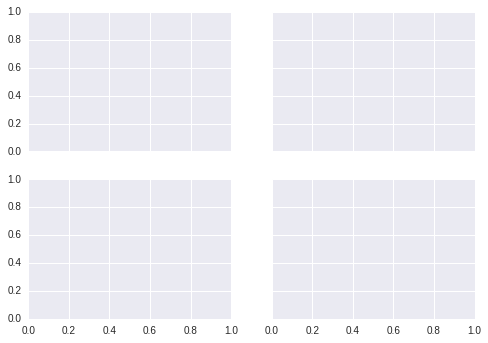

In [16]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
kde = KernelDensity(kernel='tophat').fit(dataframes[0]['CH1'])
X = dataframes[0]['CH1']
log_dens = kde.score_samples(X)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[1, 0].fill(X[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")